### Training
- Optimizer: Adam(lr=1e-4)
- Dice Loss L(yhat,y)
- Use sigmoid activation function on the prediction when using a Dice loss
    - Threshold at 0.5
        - Predictions > 0.5 ->Atriumn
        - Predictions <= 0.5 -> Not Atrium
- Train for 75 epochs

In [2]:
import imgaug.augmenters as iaa
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
from dataset import CardiacDataset
from model import UNet

In [4]:
seq = iaa.Sequential([
      iaa.Affine(scale=(0.85, 1.15),
                  rotate=(-45, 45)),
      iaa.ElasticTransformation() ])

In [5]:
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")
train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [6]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # num_workers=4,
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # num_workers=4,

In [7]:
class DiceLoss(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward (self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum
        return 1 - dice

In [8]:
from torch.optim import Adam
class AtriumSegmentation(pl.LightningModule):  
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.opt = Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
        return loss
    
    def log_images (self, mri, pred, mask, name):
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_ , alpha=0.6)

        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[1].imshow(mask_ , alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.opt]

In [9]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [10]:
checkpoint_callback = ModelCheckpoint(monitor="Val Dice", save_top_k=10, mode="min")

In [11]:
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="logs"), log_every_n_steps=1,
                    callbacks = checkpoint_callback, max_epochs=75)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import time
start_time = time.time()

trainer.fit(model, train_loader, val_loader)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Missing logger folder: logs\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\ad\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\ad\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Evaluation

In [9]:
import nibabel as nib  # load the mri scan
from tqdm.notebook import tqdm
from celluloid import Camera  # volume visualization

In [12]:
# we have the 10 best models, load one of them
model = AtriumSegmentation.load_from_checkpoint("logs/lightning_logs/version_0/checkpoints/epoch=43-step=10648.ckpt")

In [15]:
device = torch.device ("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [14]:
preds= []
labels = []
for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)  # adding 1 (the batch channel dimension)
    with torch.no_grad():   # prevent torch from accomulating the gradients
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [16]:
# Overall dice score for those predictions and labels, substract dice loss from 1
# need to convert both np arrays to tensors cause this is a torch module
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.9313)

In [17]:
# load a test scan and estimate the position of the left atrium
subject = "Task02_Heart/imagesTs/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()  # full volume

In [18]:
# Helper functions for normalization and standaraization, same as in preprocessing
def normalize(full_volume):
    ## z-normalization of the whole subject
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):  # normalized scan
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [19]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [20]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice= standardized_scan[:,:,i]
    with torch.no_grad():
        # slice is now a 2D numpy array, need to convert it to tensor
        # unsqueeze(0).unsqueeze(0) >> (channel dim and batch channel dim)
        # nifty stored as doubles , convert it to float
        # [0][0] >> remove the channel dim and batch channel dim again
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred= pred > 0.5  # threshold
    preds.append(pred.cpu())

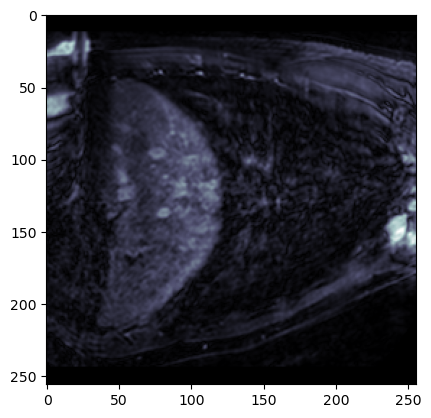

In [21]:
# visualize the volume with the corresponding predicted segmentation
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone") # visualize the current slice of the scan
    
    mask = np.ma.masked_where(preds[i]==0, preds[i]) # create seg mask by masking all zero elements in the current prediction
    plt.imshow(mask, alpha=0.5) # visualize the mask and then take the snapshot
    camera.snap()
animation = camera.animate()

In [22]:
from IPython.display import HTML
HTML(animation.to_html5_video())